#**HOMEWORK #2: VOICE IDENTIFICATION (Total: / 15 points)**

Your task is to use the sample of audio files that record different speakers saying numerical digits, and try to predict which person is speaking. You will then need to collect an audio sample of your own voice, and perform a voice identification comparison with speakers in the training data, i.e., identify a 'nearest neighbor' who sounds most like you. Separately, answer some conceptual questions in the homework assignment document. Good luck!

# *Name: (Student Name Here)*
# *Email: (Student Email Here)*

#*Import and Pre-process Data*

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 35.11 MiB/s, done.
Resolving deltas: 100% (129/129), done.


For each song, let's convert it into numeric sequences, and construct its label from the file name (the name of the speaker this time).


In [ ]:
from pathlib import Path
from scipy.signal import decimate
import glob
from scipy.io import wavfile

basePath = "free-spoken-digit-dataset/recordings"

# Downsampling to throw out unnecessary detail ends up being crucial to solving this problem! You can play with the downsampling value, but 8 is a good number here.
downsample_factor = 8

def processSong(song):

  filename = Path(song).stem
  label = filename.split("_")[1]

  sampling_rate, data = wavfile.read(song)
  return label,sampling_rate,data

labels = []
sample_rates = []
sequences = []

for i,file in enumerate(glob.glob(f"{basePath}/*.wav")):
  label, sample_rate, sequence = processSong(file)
  labels.append(label)
  sample_rates.append(sample_rate/downsample_factor)

  sequence = decimate(sequence,downsample_factor)

  sequences.append(sequence)

Pad the recordings to ensure you have a fixed sequence length (so they can fit in a single tensor).


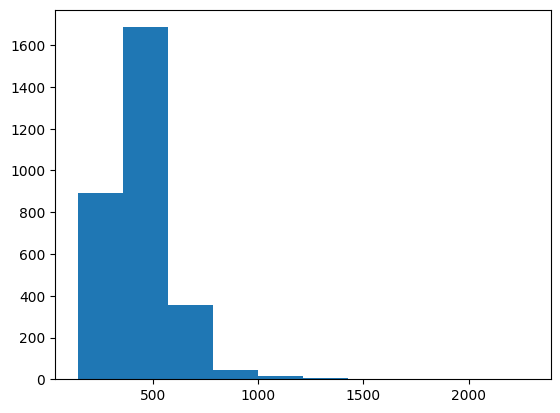

The longest list is 2283 long, but most lists are much shorter.
(3000, 2500)


In [ ]:
import tensorflow as tf
import numpy as np
import statistics
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler

len_lists = [len(x) for x in sequences]
plt.hist(len_lists)
plt.show()
print(f'The longest list is {max(len_lists)} long, but most lists are much shorter.')

# We can pad the sequences to have a common length (and chop off the end of really long ones)
labels = np.stack(labels)

# Note: sequence lengths need to be set in a reasonable way based on how much you downsampled the raw audio data.
padded_sequences = sequence.pad_sequences(sequences, maxlen=2500,padding="post", dtype='float64')

print(padded_sequences.shape)

We have six (6) people in this dataset and they seem to all be male (sorry!). Let's make a label encoder that will translate our string labels (names) into integer values.

In [ ]:
from sklearn.preprocessing import LabelEncoder

np.unique(labels)

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to your labels and transform them into numerical values
labels_encoded = label_encoder.fit_transform(labels)

#*Define Your Neural Net Architecture*

You need to define a neural network that addresses this prediction problem! Your network should take batches of audio vectors as input, pass them through 1D convolution and pooling layers, then a global pooling layer, followed by a hidden dense layer, and finally a dense output layer (in which you generate the final prediction). Note: you can insert other layers if you like, if that helps your prediction, but the second last layer (the last hidden layer) needs to be a dense layer.

In [ ]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=[padded_sequences.shape[1],1], name="input")

x =

outputs =

model = keras.Model(inputs, outputs)

#*Fit Your Model*

In [ ]:
# Compile your model
model.compile( # Specify your compilation parameters

# Callback to save your best model seen in training.
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="voice_recognition.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Fit your model
history = model.fit( # Call the fit function.

#*Plot Accuracy Over Training in Training vs. Validation Sample*

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Add plotting statements

plt.show()

#*Record Yourself*

This code creates a little applet you can then run, which accesses the microphone on your computer via the browser. It will pop up requesting permissions to access your microphone. You need to agree to proceed. If you don't want to do that, you can use the code further down to upload a recording of yourselves as a .wav file to the Colab server.

In [ ]:
!pip install ffmpeg-python

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Record yourself speaking a digit, briefly. You will be asked to grant microphone permissions in your browser, so you might need to try this a couple of times to get it to work and save the audio. Make sure the recording is no more than 1 second long! Redo it if it's longer than that, else none of this will work.

In [ ]:
import soundfile as sf

# This will launch the audio recording applet for you to record yourself saying a digit.
# You need to click the button to stop the recording!
audio, sr = get_audio()

Download your audio file to submit with your assignment solution.

In [ ]:
# Save the audio file as audio.wav
sf.write('audio.wav', audio, sr)

# Download the audio file and submit it along with your Colab notebook.
from google.colab import files
files.download('audio.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#*Or, Upload a Recording You Made Elsewhere*

In case your microphone does not work with Colab for some reason, you can record yourself some other way and upload whatever .wav soundfile you like. We will use this in grading to test the audio file you submit with the assignment. Make sure the recording is as short as our examples, e.g., no more than 1 second long!

In [ ]:
from IPython.display import Audio
from IPython.display import display

# Upload audio file, open it, and extract the audio signal and sampling rate.
files.upload()
audio, sr = sf.read('audio.wav')

sound_file = f'audio.wav'

# Play the audio file.
wn = Audio(sound_file, autoplay=True) ##
display(wn)

Note that the sampling rate is much higher than the training data! Typically this should be 48,000 Hertz.

In [ ]:
plt.plot(audio)
plt.show()
print(sr)

Downsample your recording (decimate) as we did with the training data. If you recorded yourself via the web applet I wrote, the default sampling rate should be 48,000 samples per second. Let's downsample by 48 to make the file comparable to our training data (we went from 8,000 to 1,000 samples with that data, so we need to go from 48,000 to 1,000 samples with this file). If you recorded yourself another way, you need to check the sampling rate of your .wav file and downsample (decimiate) so the result is 1,000 samples per second.

In [ ]:
audio = decimate(audio,48)

print(audio.shape)

Pad your downsampled audio and plot the audio signal.

In [ ]:
padded_audio = sequence.pad_sequences([audio],padding="post",maxlen=2500,dtype='float64')

print(padded_audio[0].shape)

plt.plot(padded_audio[0])
plt.show()

#*Extract Voice Embeddings for all Training Samples from the Last Hidden Dense Layer*

Here are all the layers in your model

In [ ]:
for layer in model.layers:
  print(layer.name)

Make a new Keras model that takes raw audio input and spits out an embedding. This model should connect your trained model's input layer to the final hidden Dense layer.

In [ ]:
input = model.input
embeds = # Specify the output layer from your network to serve as the output layer in this new model... use get_layer() by layer name, with .output on the end.
# Hint: we did something similar when looking at feature maps to visualize what CNN's detect.

model_embeds = keras.Model(input,embeds)

Now, use your new Keras embedding model to recover vector embeddings for all audio files in the training data.

In [ ]:
padded_sequences_reshaped = padded_sequences.reshape(padded_sequences.shape[0], padded_sequences.shape[1], 1)
embedding_list = model_embeds.predict_on_batch(padded_sequences_reshaped)

#*Compare Your File's Embedding with Embeddings from Training Audio Files*

In [ ]:
my_embedding = model_embeds.predict([padded_audio])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


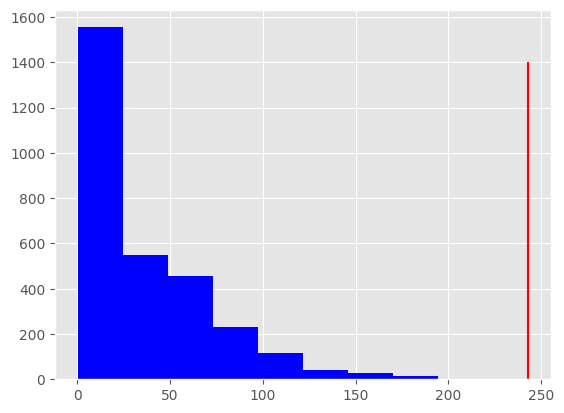

Our closest embedding match is with audio file 2671, which was spoken by jackson. Our similarity score based on vector dot product was 243.2519989013672.


In [ ]:
top_similarity_index = None
top_similarity_score = 0

similarity_scores = []

for i,embedding in enumerate(embedding_list):

  pairwise_similarity = np.dot(my_embedding,embedding)
  similarity_scores.append(pairwise_similarity)

  if pairwise_similarity > top_similarity_score:
    top_similarity_score = pairwise_similarity
    top_similarity_index = i

plt.hist(similarity_scores,color='blue')
plt.vlines(top_similarity_score,0,1400,'r')
plt.show()

print(f'Our closest embedding match is with audio file {top_similarity_index}, which was spoken by {labels[top_similarity_index]}. Our similarity score based on vector dot product was {top_similarity_score}.')

In [ ]:
from IPython.display import Audio
from IPython.display import display
import librosa.display
import librosa

# What's the name of the file?

for i,file in enumerate(glob.glob(f"{basePath}/*.wav")):

  if i == top_similarity_index:
    sound_file = f'{file}'
    print(sound_file)

    # Play the audio file.
    wn = Audio(sound_file, autoplay=True) ##
    display(wn)

    break

free-spoken-digit-dataset/recordings/0_jackson_41.wav
